In [2]:
library(igraph)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(viridis)

This build of rgl does not include OpenGL functions.  Use
 rglwidget() to display results, e.g. via options(rgl.printRglwidget = TRUE).

Loading required package: viridisLite



[1] 57.57352

[1] 4.427521

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


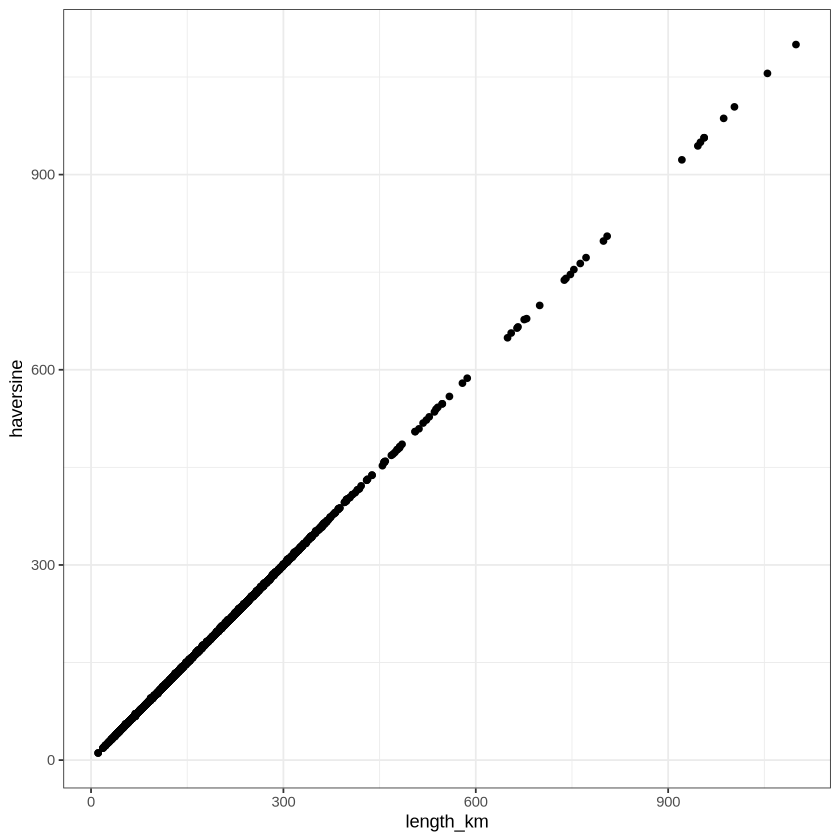

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


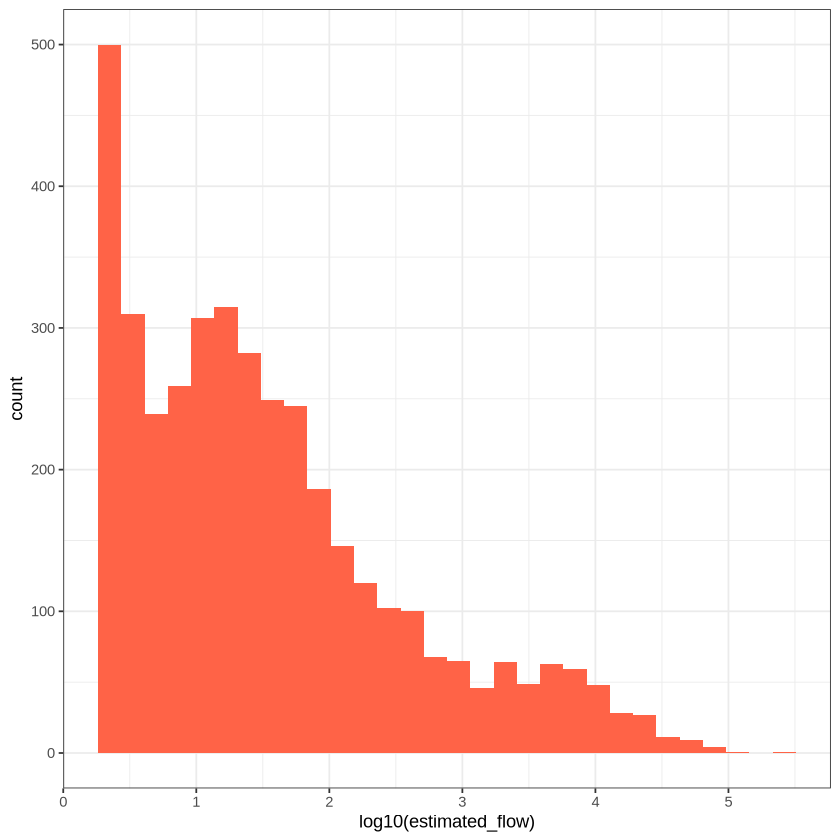

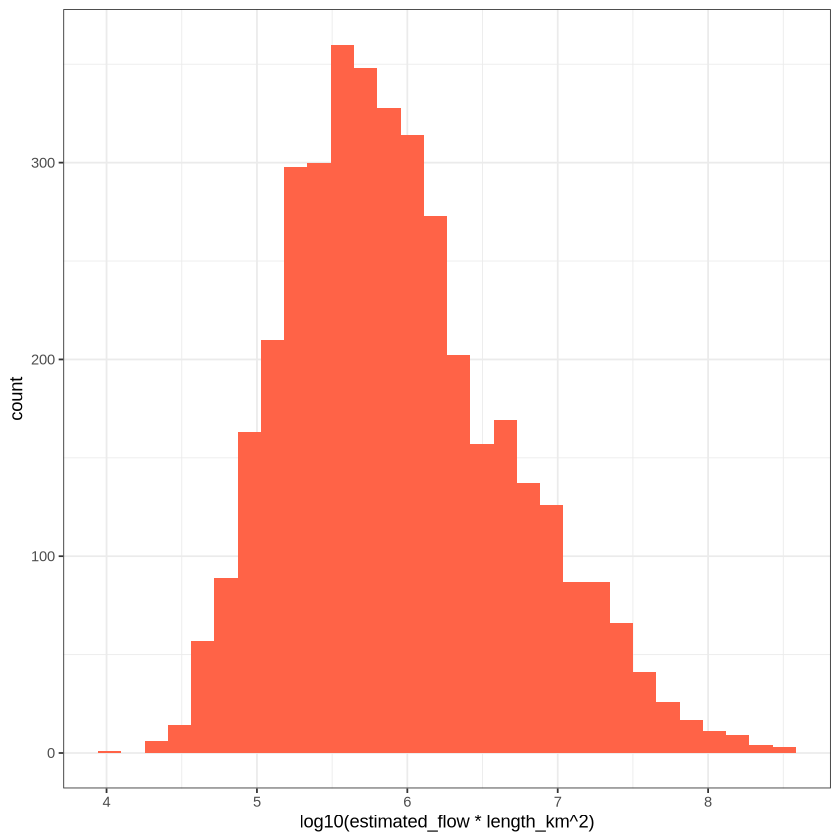

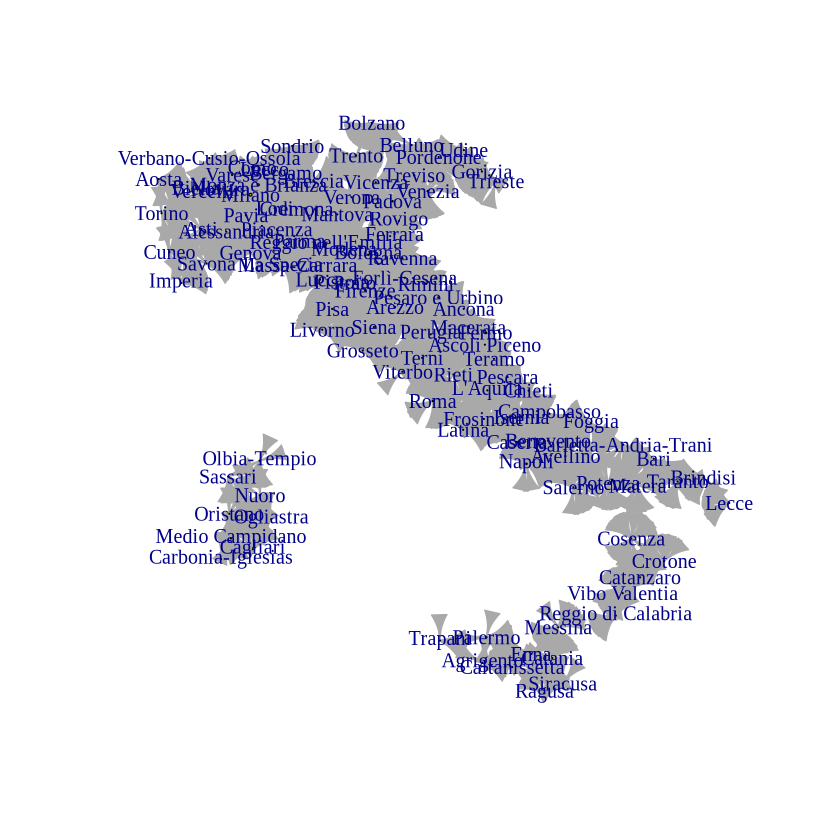

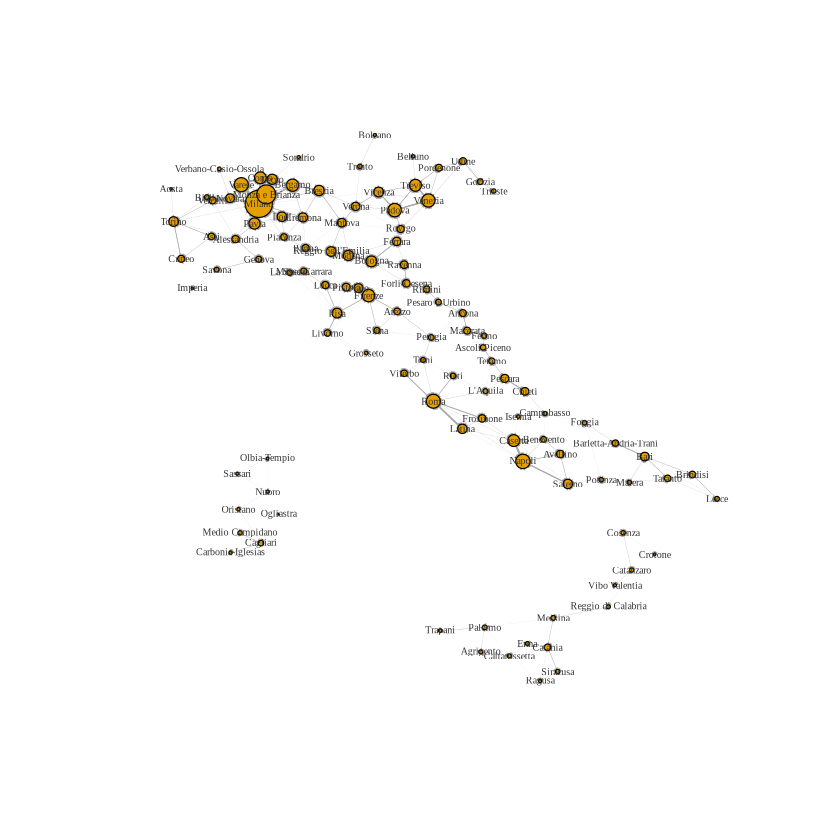

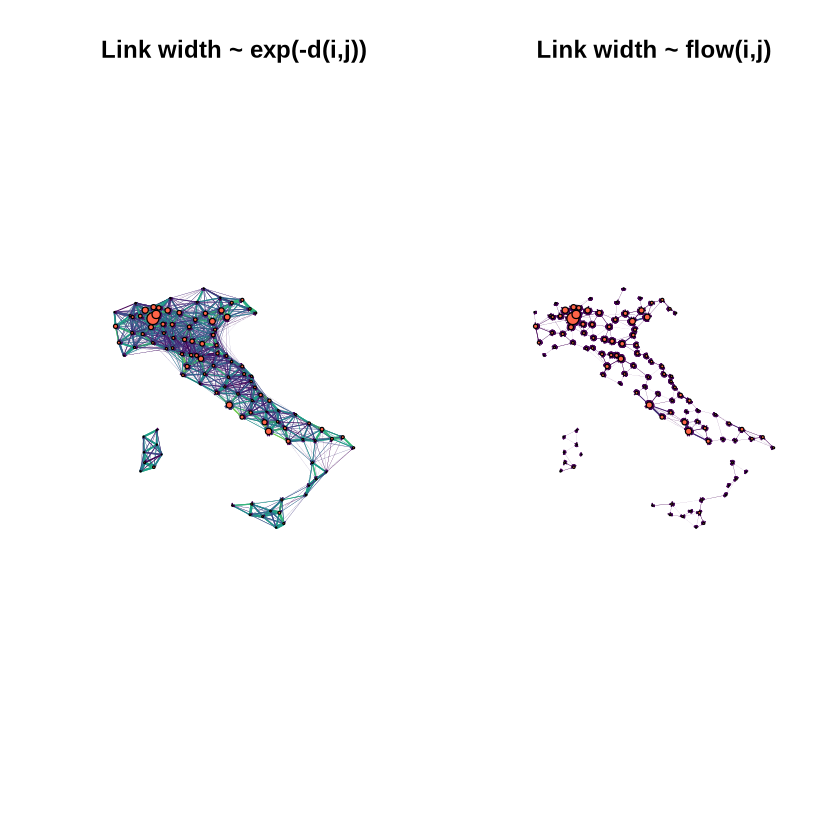

In [3]:
# download:
# https://manliodedomenico.com/tmp/ITA_edges.csv
# https://manliodedomenico.com/tmp/ITA_nodes.csv

source("/home/pietromalagoli/PCN/common.R")

# Import the data
dat_nodes <- read.csv("ITA_nodes.csv", header=T, sep=",")
dat_edges <- read.csv("ITA_edges.csv", header=T, sep=",")

dat_nodes$lat <- as.numeric(dat_nodes$lat)
dat_nodes$lon <- as.numeric(dat_nodes$lon)
dat_nodes <- dat_nodes[order(dat_nodes$adm_id),]
rownames(dat_nodes) <- dat_nodes$adm_id

# Get an idea of the orders of magnitude

sum(dat_edges$estimated_flow)*1e-6

# Filter out self-loops and links with zero flow

dat_edges <- dat_edges[which(dat_edges$from!=dat_edges$to & dat_edges$estimated_flow>0),]
sum(dat_edges$estimated_flow)*1e-6


# Dont trust the length_km field, let us calculate the distances by ourselves
# install the geosphere package
dat_edges$haversine <- 1e-3*geosphere::distHaversine( cbind(dat_nodes[dat_edges$from,]$lon,dat_nodes[dat_edges$from,]$lat), cbind(dat_nodes[dat_edges$to,]$lon,dat_nodes[dat_edges$to,]$lat) )

# if length_km was correct, then the two measures should correlate very well, and they do
ggplot(dat_edges, aes(length_km, haversine)) + theme_bw() + geom_point()



ggplot(dat_edges, aes(log10(estimated_flow))) + theme_bw() + geom_histogram(fill="tomato")
ggplot(dat_edges, aes(log10(estimated_flow*length_km^2))) + theme_bw() + geom_histogram(fill="tomato")


# Build the moblity network

g <- graph_from_data_frame(dat_edges[,c("from", "to")], directed=T, vertices=sort(dat_nodes$adm_id))
E(g)$weight <- dat_edges$estimated_flow
V(g)$pop <- dat_nodes$population
V(g)$label <- dat_nodes$adm_name


# Set the layout for plotting the network

layout <- matrix(NA, nrow(dat_nodes), 2)
layout[,1] <- dat_nodes$lon
layout[,2] <- dat_nodes$lat


# Visualize

sizes_nodes <- sqrt(strength(g, mode="all"))
sizes_edges <- E(g)$weight

plot(g, layout=layout, vertex.size=sizes_nodes/max(sizes_nodes), edge.width=sizes_edges/max(sizes_edges))

# fix the appearance

plot(g, layout=layout, vertex.label=V(g)$label, vertex.label.cex=.5, vertex.label.color="gray20", vertex.size=10*sizes_nodes/max(sizes_nodes), edge.arrow.size=0.05, edge.arrow.width=0.05, edge.width=5*sizes_edges/max(sizes_edges))



# let's use our distance for the visualization
# need the viridis package installed
mypal <- viridis::viridis_pal()(10)

par(mfrow=c(1,2))

w <- log10(E(g)$weight)
edge_colors <- vec2pal(w, mypal)
sizes_edges <- exp(-dat_edges$haversine/40)

plot(g, layout=layout, 
        vertex.label=NA, 
        vertex.label.cex=.5, 
        vertex.label.color="gray20", 
        vertex.color="tomato",
        vertex.size=10*sizes_nodes/max(sizes_nodes), 
        edge.arrow.size=0.05, 
        edge.arrow.width=0.05, 
        edge.width=5*sizes_edges/max(sizes_edges), 
        edge.color=edge_colors,
        main="Link width ~ exp(-d(i,j))")


w <- E(g)$weight
edge_colors <- vec2pal(w, mypal)
sizes_edges <- w

plot(g, layout=layout, 
        vertex.label=NA, 
        vertex.label.cex=.5, 
        vertex.label.color="gray20", 
        vertex.color="tomato",
        vertex.size=10*sizes_nodes/max(sizes_nodes), 
        edge.arrow.size=0.05, 
        edge.arrow.width=0.05, 
        edge.width=5*sizes_edges/max(sizes_edges), 
        edge.color=edge_colors,
        main="Link width ~ flow(i,j)")
